In [2]:
 pip install catboost xgboost lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.4 MB/s eta 0:00:00


In [3]:

# ====================================================================
# STEP 1: IMPORTS AND SETUP
# ====================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
# Model selection
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
# Imbalanced learning
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
# Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             roc_curve, precision_recall_curve, average_precision_score,
                             log_loss)
# For loss curves
from sklearn.model_selection import train_test_split as additional_split
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [4]:
# ====================================================================
# STEP 2: LOAD AND EXPLORE DATA WITH MISSING VALUE HANDLING
# ====================================================================
print("Loading and exploring data...")
df = pd.read_csv("german_credit_clean.csv")
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
# Check for missing values
print("\n" + "="*80)
print("MISSING VALUES ANALYSIS:")
print("="*80)
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_values, 'Missing %': missing_percent})
print(missing_df[missing_df['Missing Count'] > 0])
# Handle missing values
print("\nHandling missing values...")
df_clean = df.copy()
# Check unique values in each column to understand data
print("\nUnique values in categorical columns:")
categorical_cols = ['Housing', 'Saving_accounts', 'Checking_account', 'Purpose', 'Risk']
for col in categorical_cols:
    if col in df_clean.columns:
        print(f"{col}: {df_clean[col].unique()}")
# Target distribution
print("\n" + "="*80)
print("TARGET DISTRIBUTION:")
print("="*80)
target_dist = df_clean['Risk'].value_counts()
print(target_dist)
print(f"\nPercentage: {target_dist / len(df_clean) * 100}")
print(f"Imbalance ratio: {target_dist['good'] / target_dist['bad']:.2f}:1")

Loading and exploring data...
Dataset shape: (1000, 9)

Columns: ['Age', 'Job', 'Housing', 'Saving_accounts', 'Checking_account', 'Credit_amount', 'Duration', 'Purpose', 'Risk']

MISSING VALUES ANALYSIS:
Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []

Handling missing values...

Unique values in categorical columns:
Housing: ['own' 'free' 'rent']
Saving_accounts: ['unknown' 'little' 'quite rich' 'rich' 'moderate']
Checking_account: [  0. 200. 500.]
Purpose: ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'others' 'retraining']
Risk: ['good' 'bad']

TARGET DISTRIBUTION:
Risk
good    700
bad     300
Name: count, dtype: int64

Percentage: Risk
good    70.0
bad     30.0
Name: count, dtype: float64
Imbalance ratio: 2.33:1



EXPLORATORY DATA ANALYSIS (EDA):


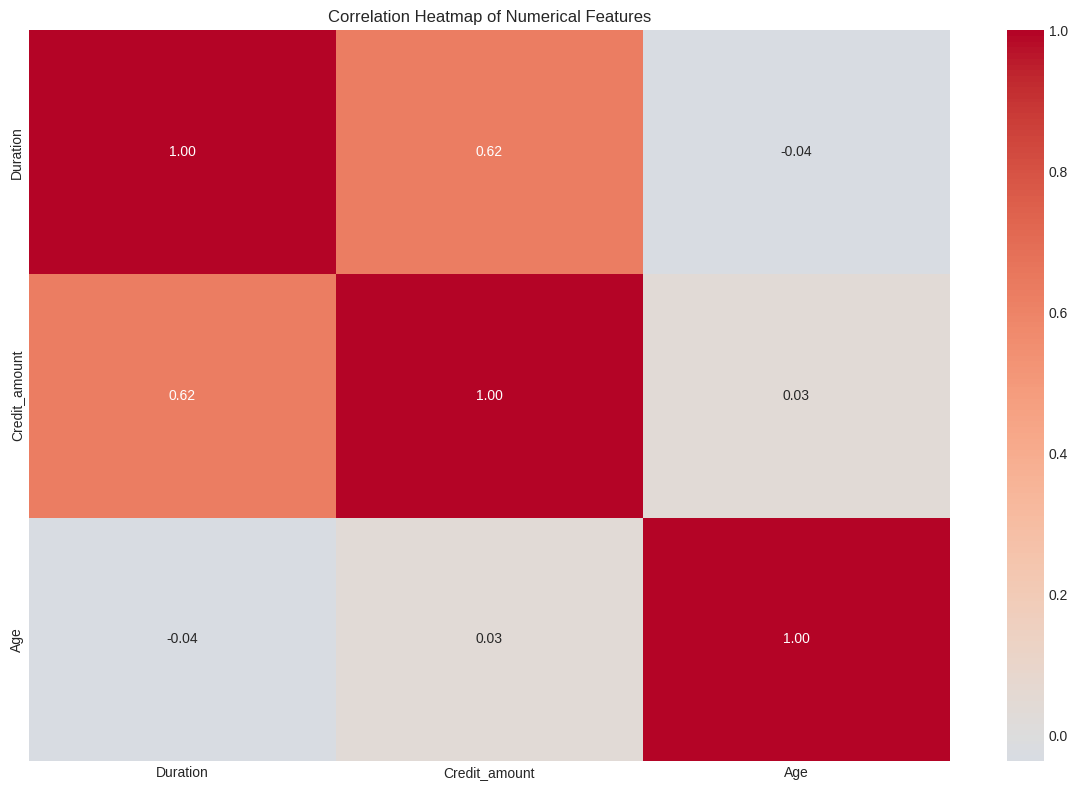

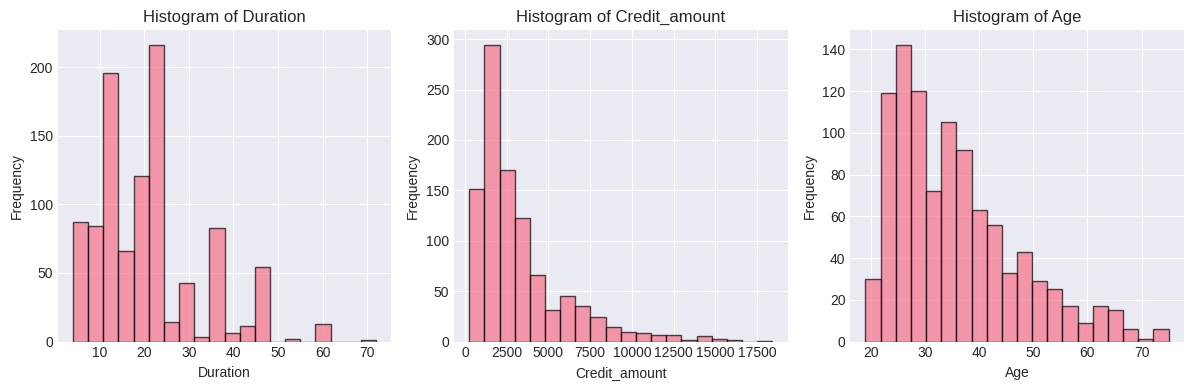

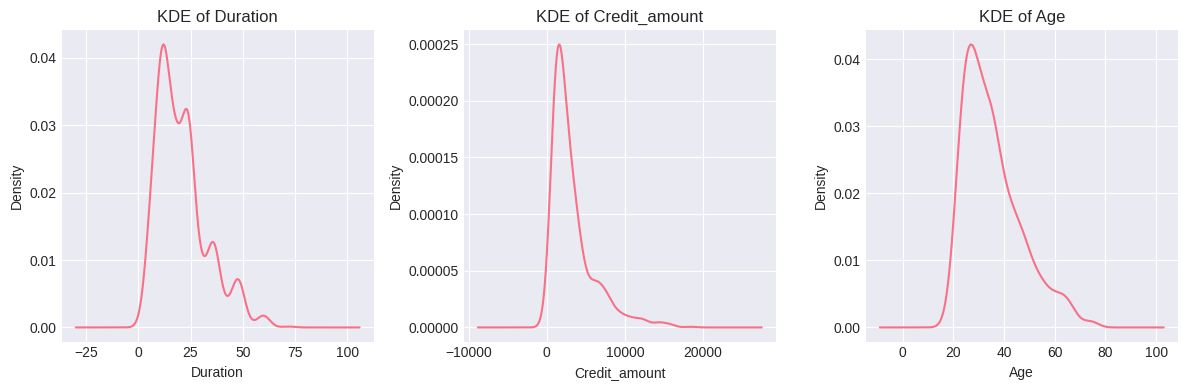

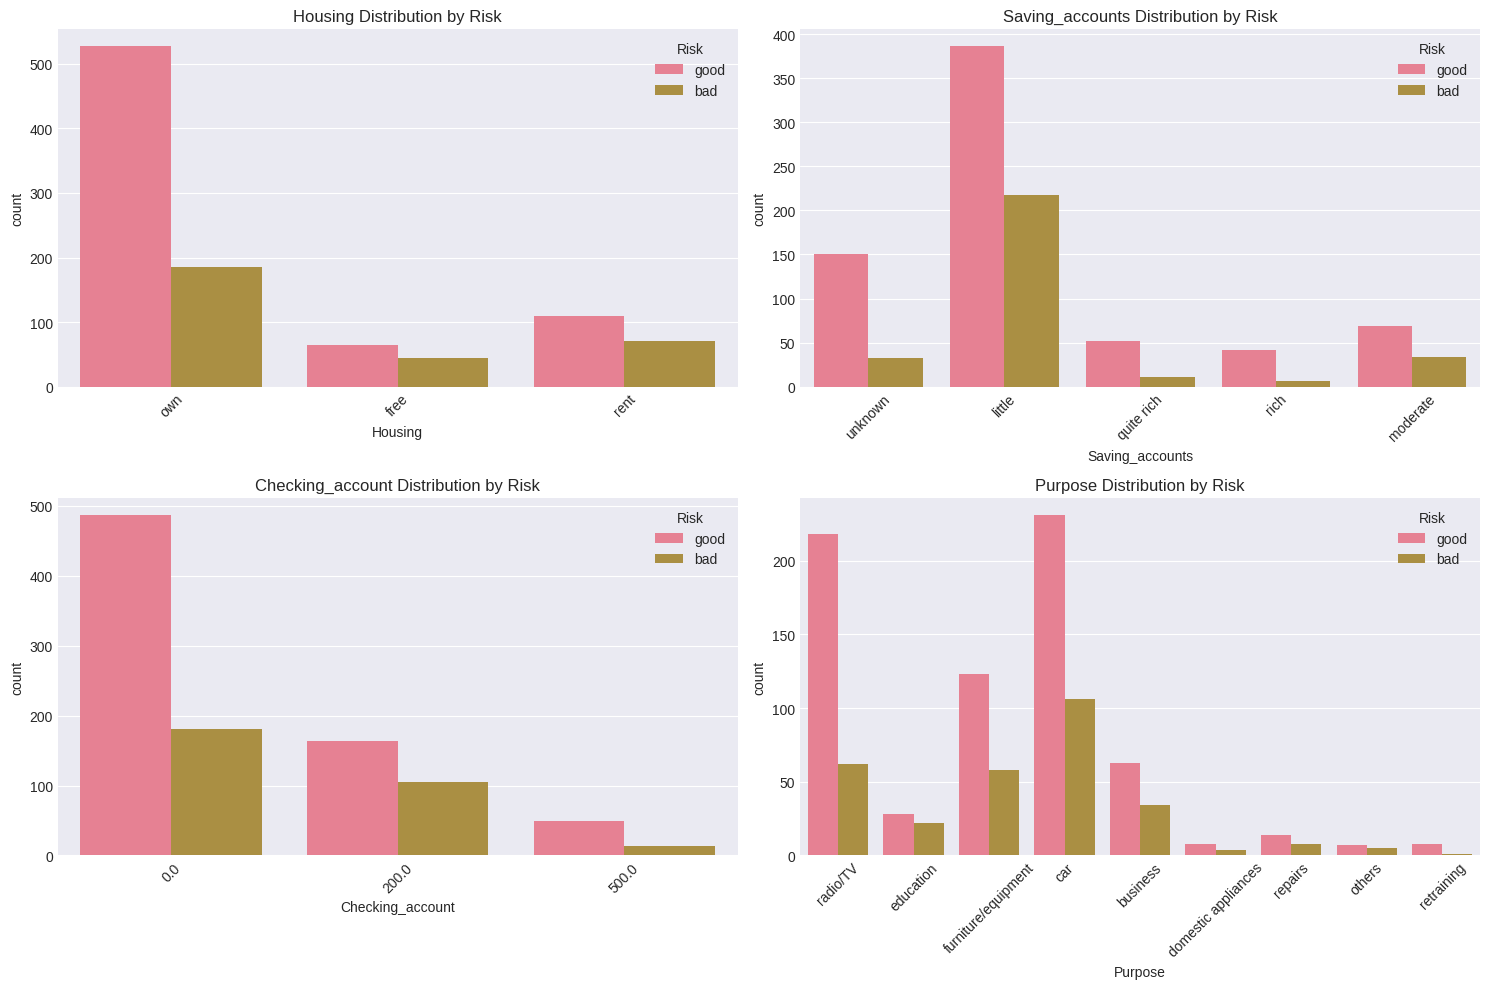

In [5]:
# ====================================================================
# STEP 2.5: EXPLORATORY DATA ANALYSIS (EDA)
# ====================================================================
print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS (EDA):")
print("="*80)

# Assume numerical columns based on standard German Credit dataset
numerical_cols = ['Duration', 'Credit_amount', 'Age', 'Installment_rate', 'Residence_duration',
                  'Number_credits', 'People_liable']  # Adjust if column names differ

# Ensure columns exist
numerical_cols = [col for col in numerical_cols if col in df_clean.columns]

# 1. Correlation Heatmap
if len(numerical_cols) > 1:
    plt.figure(figsize=(12, 8))
    corr = df_clean[numerical_cols].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Correlation Heatmap of Numerical Features')
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png', dpi=100)
    plt.show()

# 2. Histograms for numerical features
if numerical_cols:
    n_cols = 4
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
    axes = axes.ravel()
    for i, col in enumerate(numerical_cols):
        if i < len(axes):
            axes[i].hist(df_clean[col], bins=20, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Histogram of {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
    # Hide unused subplots
    for i in range(len(numerical_cols), len(axes)):
        axes[i].set_visible(False)
    plt.tight_layout()
    plt.savefig('histograms_numerical.png', dpi=100)
    plt.show()

# 3. KDE plots for numerical features
if numerical_cols:
    n_cols = 4
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
    axes = axes.ravel()
    for i, col in enumerate(numerical_cols):
        if i < len(axes):
            df_clean[col].plot.kde(ax=axes[i])
            axes[i].set_title(f'KDE of {col}')
            axes[i].set_xlabel(col)
    # Hide unused subplots
    for i in range(len(numerical_cols), len(axes)):
        axes[i].set_visible(False)
    plt.tight_layout()
    plt.savefig('kde_numerical.png', dpi=100)
    plt.show()

# 4. Bar plots for categorical features vs Target (Risk)
categorical_cols_plot = ['Housing', 'Saving_accounts', 'Checking_account', 'Purpose']
categorical_cols_plot = [col for col in categorical_cols_plot if col in df_clean.columns]

n_cols = 2
n_rows = (len(categorical_cols_plot) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.ravel()
for i, col in enumerate(categorical_cols_plot):
    if i < len(axes):
        sns.countplot(data=df_clean, x=col, hue='Risk', ax=axes[i])
        axes[i].set_title(f'{col} Distribution by Risk')
        axes[i].tick_params(axis='x', rotation=45)
# Hide unused subplots
for i in range(len(categorical_cols_plot), len(axes)):
    axes[i].set_visible(False)
plt.tight_layout()
plt.savefig('categorical_barplots_vs_risk.png', dpi=100)
plt.show()

In [6]:
# ====================================================================
# STEP 3: ADVANCED FEATURE ENGINEERING
# ====================================================================
print("\n" + "="*80)
print("ADVANCED FEATURE ENGINEERING:")
print("="*80)
# Create a copy for feature engineering
df_fe = df_clean.copy()
# 1. Target encoding first
df_fe['target'] = df_fe['Risk'].map({'good': 0, 'bad': 1})
y = df_fe['target']
df_fe = df_fe.drop('Risk', axis=1)
# 2. Fill missing values before feature engineering
print("Filling missing values...")
# Check which columns have missing values
cols_with_missing = df_fe.columns[df_fe.isnull().any()].tolist()
print(f"Columns with missing values: {cols_with_missing}")
# Fill numerical columns with median
numerical_cols = df_fe.select_dtypes(include=[np.number]).columns.tolist()
for col in numerical_cols:
    if col in cols_with_missing:
        median_val = df_fe[col].median()
        df_fe[col] = df_fe[col].fillna(median_val)
        print(f" Filled {col} with median: {median_val}")
# Fill categorical columns with mode
categorical_cols_fe = ['Housing', 'Saving_accounts', 'Checking_account', 'Purpose']
for col in categorical_cols_fe:
    if col in df_fe.columns and df_fe[col].isnull().any():
        mode_val = df_fe[col].mode()[0]
        df_fe[col] = df_fe[col].fillna(mode_val)
        print(f" Filled {col} with mode: {mode_val}")
# 3. Create powerful interaction features
print("\nCreating interaction features...")
# Fix Checking_account column - handle string values
df_fe['Checking_account'] = df_fe['Checking_account'].astype(str)
# Financial capacity features
df_fe['credit_per_month'] = df_fe['Credit_amount'] / (df_fe['Duration'] + 1)
df_fe['credit_to_income_ratio'] = df_fe['Credit_amount'] / (df_fe['Age'] * 100 + 1000)
# Age-based features
df_fe['age_group'] = pd.cut(df_fe['Age'], bins=[18, 25, 35, 45, 60, 100], labels=[1, 2, 3, 4, 5])
df_fe['is_young'] = (df_fe['Age'] < 30).astype(int)
df_fe['is_senior'] = (df_fe['Age'] > 50).astype(int)
# Credit amount segmentation
df_fe['credit_segment'] = pd.qcut(df_fe['Credit_amount'], q=5, labels=[1, 2, 3, 4, 5])
df_fe['high_credit'] = (df_fe['Credit_amount'] > df_fe['Credit_amount'].median()).astype(int)
# Duration features
df_fe['long_duration'] = (df_fe['Duration'] > 24).astype(int)
df_fe['credit_per_month_segment'] = pd.qcut(df_fe['credit_per_month'], q=4, labels=[1, 2, 3, 4])
# Account status features - handle Checking_account properly
# Convert Checking_account to numeric, handle 'unknown'
def parse_checking_account(val):
    try:
        return float(val)
    except:
        return 0.0 # Treat unknown as 0
df_fe['Checking_account_numeric'] = df_fe['Checking_account'].apply(parse_checking_account)
df_fe['has_checking_account'] = (df_fe['Checking_account_numeric'] > 0).astype(int)
# Job stability features
df_fe['job_stability'] = df_fe['Job'].map({0: 0, 1: 1, 2: 2, 3: 3})
# Housing risk features
df_fe['housing_risk'] = df_fe['Housing'].map({'own': 0, 'rent': 1, 'free': 2})
# Purpose risk encoding
purpose_risk_map = {
    'radio/TV': 2,
    'education': 1,
    'furniture/equipment': 2,
    'car': 3,
    'business': 4,
    'domestic appliances': 1,
    'repairs': 1,
    'vacation/others': 2
}
df_fe['purpose_risk_score'] = df_fe['Purpose'].map(purpose_risk_map)
# Saving accounts encoding
saving_risk_map = {
    'little': 3,
    'moderate': 2,
    'rich': 1,
    'unknown': 2
}
df_fe['saving_risk_score'] = df_fe['Saving_accounts'].map(saving_risk_map)
# Combined risk scores
df_fe['total_risk_score'] = (df_fe['purpose_risk_score'] + df_fe['saving_risk_score'] + df_fe['housing_risk']) / 3
# Create polynomial features
print("Creating polynomial features...")
for col in ['Credit_amount', 'Duration', 'Age', 'credit_per_month']:
    if col in df_fe.columns:
        df_fe[f'{col}_squared'] = df_fe[col] ** 2
        df_fe[f'{col}_log'] = np.log1p(df_fe[col])
        df_fe[f'{col}_sqrt'] = np.sqrt(df_fe[col])
# Create ratio features
df_fe['age_to_duration_ratio'] = df_fe['Age'] / (df_fe['Duration'] + 1)
df_fe['credit_to_age_ratio'] = df_fe['Credit_amount'] / (df_fe['Age'] + 20)
print(f"Original features: {len(df_clean.columns)}")
print(f"After feature engineering: {len(df_fe.columns)}")


ADVANCED FEATURE ENGINEERING:
Filling missing values...
Columns with missing values: []

Creating interaction features...
Creating polynomial features...
Original features: 9
After feature engineering: 39


In [7]:
# ====================================================================
# STEP 4: ENCODING CATEGORICAL VARIABLES
# ====================================================================
print("\n" + "="*80)
print("ENCODING CATEGORICAL VARIABLES:")
print("="*80)
# Get categorical columns
categorical_cols_to_encode = ['Housing', 'Saving_accounts', 'Purpose']
# 1. One-Hot Encoding
df_encoded = pd.get_dummies(df_fe, columns=categorical_cols_to_encode, drop_first=True)
# 2. Convert Checking_account to categorical features
checking_dummies = pd.get_dummies(df_fe['Checking_account'], prefix='Checking', drop_first=True)
df_encoded = pd.concat([df_encoded, checking_dummies], axis=1)
# Drop original columns
columns_to_drop = ['Checking_account', 'Checking_account_numeric', 'age_group',
                   'credit_segment', 'credit_per_month_segment']
for col in columns_to_drop:
    if col in df_encoded.columns:
        df_encoded = df_encoded.drop(col, axis=1)
# Remove target for X
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']
print(f"Final feature count: {X.shape[1]}")
print(f"\nSample of columns: {X.columns.tolist()[:20]}...")


ENCODING CATEGORICAL VARIABLES:
Final feature count: 46

Sample of columns: ['Age', 'Job', 'Credit_amount', 'Duration', 'credit_per_month', 'credit_to_income_ratio', 'is_young', 'is_senior', 'high_credit', 'long_duration', 'has_checking_account', 'job_stability', 'housing_risk', 'purpose_risk_score', 'saving_risk_score', 'total_risk_score', 'Credit_amount_squared', 'Credit_amount_log', 'Credit_amount_sqrt', 'Duration_squared']...


In [8]:
# ====================================================================
# STEP 5: TRAIN-TEST SPLIT WITH STRATIFICATION
# ====================================================================
print("\n" + "="*80)
print("TRAIN-TEST SPLIT:")
print("="*80)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTraining target distribution:\n{y_train.value_counts()}")
print(f"\nTest target distribution:\n{y_test.value_counts()}")


TRAIN-TEST SPLIT:
Training set: (800, 46)
Test set: (200, 46)

Training target distribution:
target
0    560
1    240
Name: count, dtype: int64

Test target distribution:
target
0    140
1     60
Name: count, dtype: int64


In [9]:
# ====================================================================
# STEP 6: SIMPLE FEATURE SELECTION (WITH PROPER NAN HANDLING)
# ====================================================================
print("\n" + "="*80)
print("FEATURE SELECTION:")
print("="*80)
# First, ensure there are no NaN values in X_train and X_test
print("Checking for NaN values...")
print(f"NaN in X_train: {X_train.isnull().sum().sum()}")
print(f"NaN in X_test: {X_test.isnull().sum().sum()}")
# If there are NaN values, fill them
if X_train.isnull().sum().sum() > 0 or X_test.isnull().sum().sum() > 0:
    print("\nFilling NaN values...")

    # Get numeric and categorical columns
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

    # Fill numeric columns with median
    for col in numeric_cols:
        if X_train[col].isnull().any():
            median_val = X_train[col].median()
            X_train[col] = X_train[col].fillna(median_val)
            X_test[col] = X_test[col].fillna(median_val)
            print(f" Filled {col} with median: {median_val}")

    # Fill categorical columns with mode
    for col in categorical_cols:
        if X_train[col].isnull().any():
            mode_val = X_train[col].mode()[0]
            X_train[col] = X_train[col].fillna(mode_val)
            X_test[col] = X_test[col].fillna(mode_val)
            print(f" Filled {col} with mode: {mode_val}")
print(f"\nAfter NaN handling:")
print(f"NaN in X_train: {X_train.isnull().sum().sum()}")
print(f"NaN in X_test: {X_test.isnull().sum().sum()}")
# Remove constant features
from sklearn.feature_selection import VarianceThreshold
var_threshold = VarianceThreshold(threshold=0.01)
X_train_var = var_threshold.fit_transform(X_train)
X_test_var = var_threshold.transform(X_test)
# Get the selected columns
selected_columns = X_train.columns[var_threshold.get_support()]
X_train_var_df = pd.DataFrame(X_train_var, columns=selected_columns, index=X_train.index)
X_test_var_df = pd.DataFrame(X_test_var, columns=selected_columns, index=X_test.index)
print(f"\nAfter removing constant features: {X_train_var_df.shape[1]} features")
# Use mutual information for feature selection
from sklearn.feature_selection import mutual_info_classif
# Calculate mutual information
print("\nCalculating mutual information...")
mi_scores = mutual_info_classif(X_train_var_df, y_train, random_state=42)
mi_scores_series = pd.Series(mi_scores, index=selected_columns)
top_features = mi_scores_series.nlargest(25).index.tolist()
print(f"\nSelected top 25 features based on mutual information")
print(f"Selected features: {top_features[:10]}...")
# Select only top features
X_train_selected = X_train_var_df[top_features]
X_test_selected = X_test_var_df[top_features]
print(f"\nFinal training set shape: {X_train_selected.shape}")
print(f"Final test set shape: {X_test_selected.shape}")
# Double-check for NaN values
print(f"\nFinal NaN check:")
print(f"NaN in X_train_selected: {X_train_selected.isnull().sum().sum()}")
print(f"NaN in X_test_selected: {X_test_selected.isnull().sum().sum()}")
# If there are still NaN values, fill them
if X_train_selected.isnull().sum().sum() > 0 or X_test_selected.isnull().sum().sum() > 0:
    print("\nFilling remaining NaN values...")

    # Fill with median for each column
    for col in X_train_selected.columns:
        if X_train_selected[col].isnull().any():
            median_val = X_train_selected[col].median()
            X_train_selected[col] = X_train_selected[col].fillna(median_val)
            X_test_selected[col] = X_test_selected[col].fillna(median_val)
            print(f" Filled {col} with median: {median_val}")
print(f"\nFinal verification:")
print(f"NaN in X_train_selected: {X_train_selected.isnull().sum().sum()}")
print(f"NaN in X_test_selected: {X_test_selected.isnull().sum().sum()}")


FEATURE SELECTION:
Checking for NaN values...
NaN in X_train: 121
NaN in X_test: 46

Filling NaN values...
 Filled purpose_risk_score with median: 2.0
 Filled saving_risk_score with median: 3.0
 Filled total_risk_score with median: 1.6666666666666667

After NaN handling:
NaN in X_train: 0
NaN in X_test: 0

After removing constant features: 44 features

Calculating mutual information...

Selected top 25 features based on mutual information
Selected features: ['Duration', 'saving_risk_score', 'Job', 'total_risk_score', 'Duration_sqrt', 'Credit_amount_sqrt', 'Credit_amount', 'Checking_200.0', 'housing_risk', 'Credit_amount_log']...

Final training set shape: (800, 25)
Final test set shape: (200, 25)

Final NaN check:
NaN in X_train_selected: 0
NaN in X_test_selected: 0

Final verification:
NaN in X_train_selected: 0
NaN in X_test_selected: 0


In [10]:
# ====================================================================
# STEP 7: HANDLE CLASS IMBALANCE
# ====================================================================
print("\n" + "="*80)
print("HANDLING CLASS IMBALANCE:")
print("="*80)
# Use SMOTE for resampling
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)
print(f"Before SMOTE: {X_train_selected.shape}, Class distribution: {y_train.value_counts().to_dict()}")
print(f"After SMOTE: {X_train_resampled.shape}, Class distribution: {pd.Series(y_train_resampled).value_counts().to_dict()}")

# Split resampled data for validation to plot loss curves
X_train_split, X_val, y_train_split, y_val = additional_split(
    X_train_resampled, y_train_resampled, test_size=0.2, random_state=42, stratify=y_train_resampled
)



HANDLING CLASS IMBALANCE:
Before SMOTE: (800, 25), Class distribution: {0: 560, 1: 240}
After SMOTE: (1120, 25), Class distribution: {1: 560, 0: 560}



BUILDING AND COMPARING MODELS WITH TRAIN/VALIDATION LOSS CURVES:

Training XGBoost...


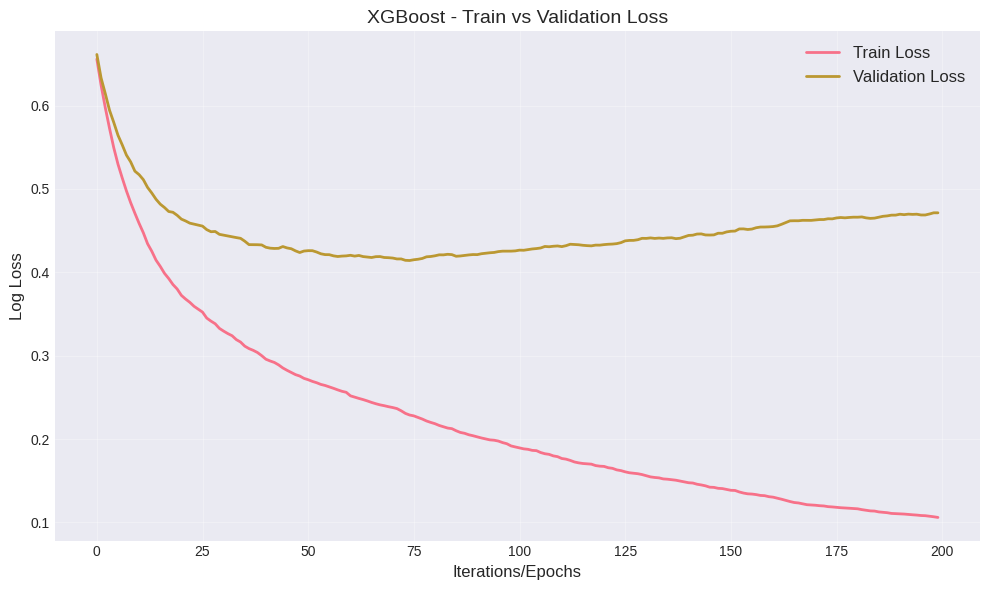

 Accuracy: 0.6600 | F1: 0.4333 | ROC-AUC: 0.6512

Training Random Forest...


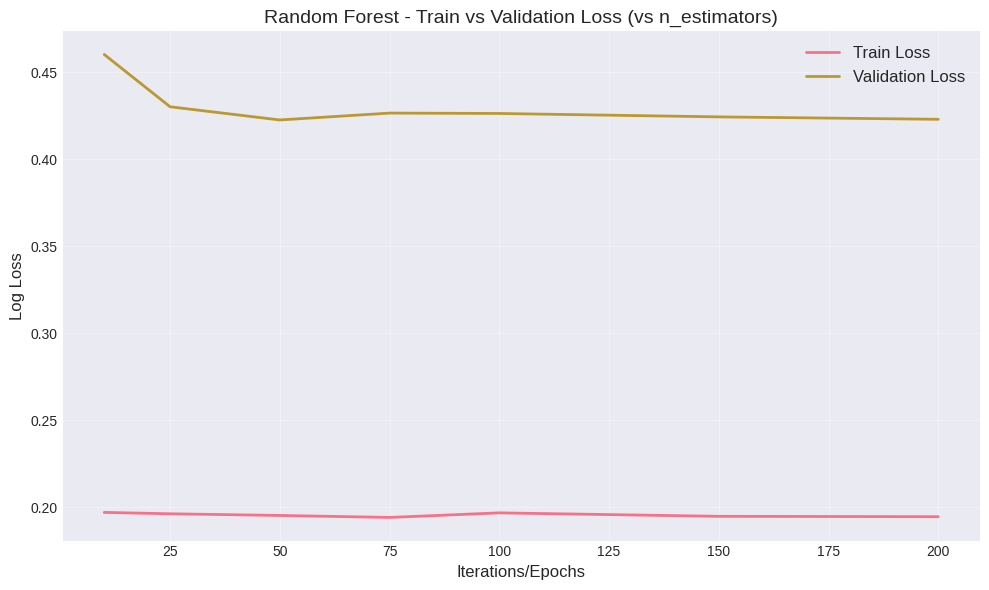

 Accuracy: 0.6900 | F1: 0.4655 | ROC-AUC: 0.6605

Training LightGBM...
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[57]	training's binary_logloss: 0.27575	valid_1's binary_logloss: 0.426874


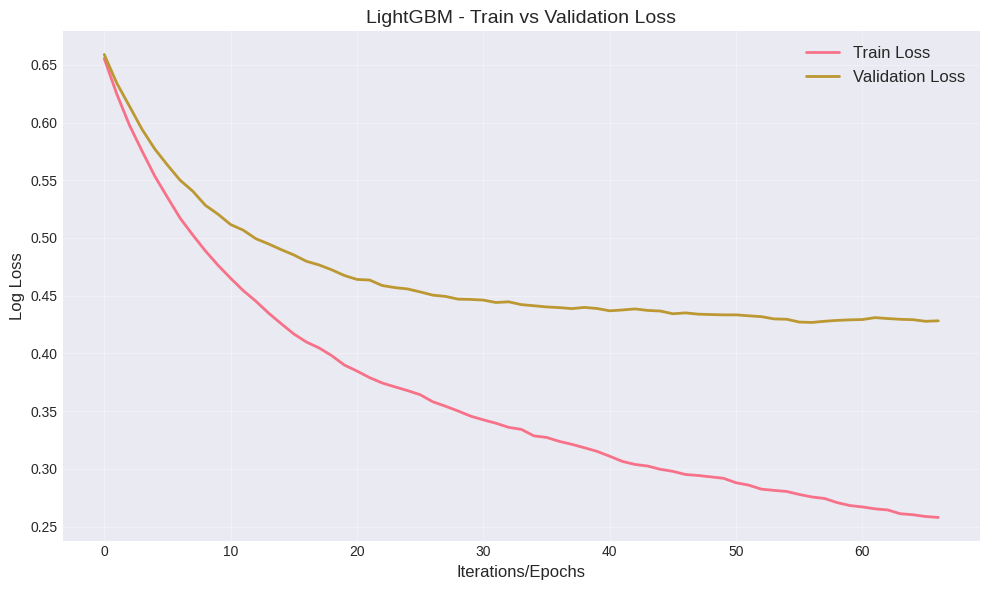

 Accuracy: 0.6700 | F1: 0.4107 | ROC-AUC: 0.6645

Training Logistic Regression...


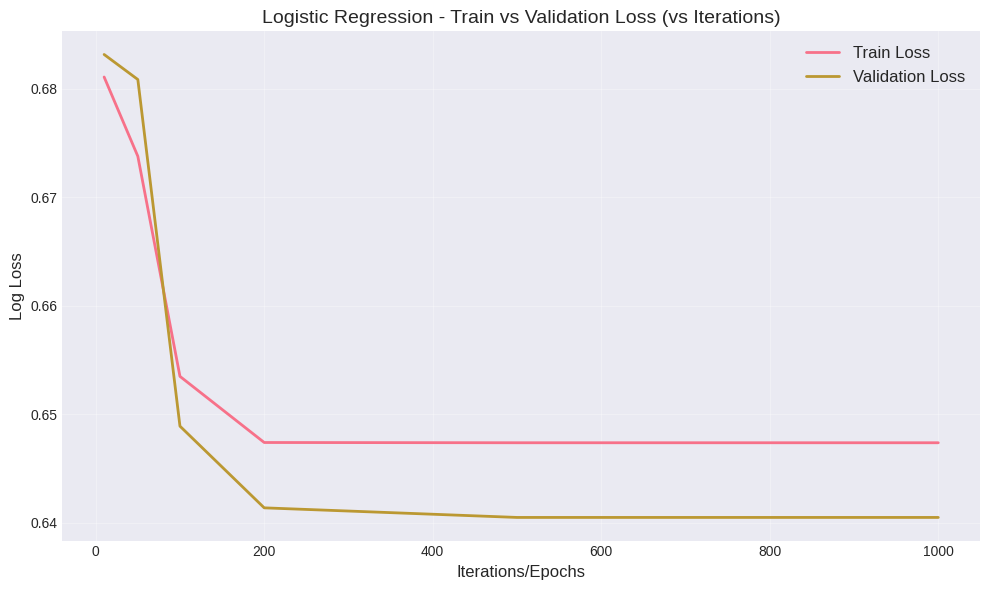

 Accuracy: 0.6500 | F1: 0.5000 | ROC-AUC: 0.6549

Training Gradient Boosting...


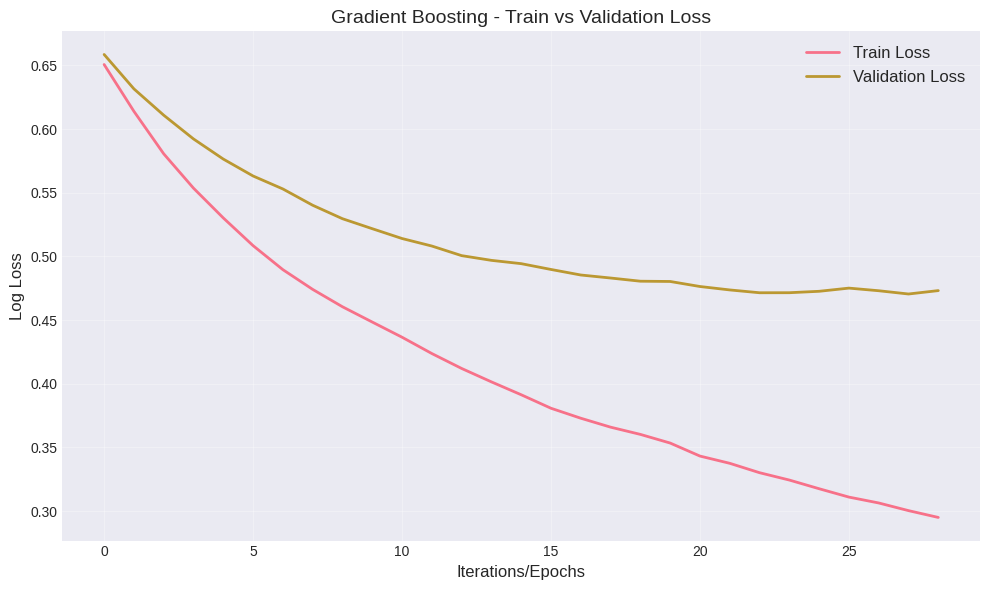

 Accuracy: 0.6850 | F1: 0.4220 | ROC-AUC: 0.6495

FINAL MODEL RANKING (by ROC-AUC):
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
           LightGBM     0.670     0.4423  0.3833    0.4107   0.6645
      Random Forest     0.690     0.4821  0.4500    0.4655   0.6605
Logistic Regression     0.650     0.4375  0.5833    0.5000   0.6549
            XGBoost     0.660     0.4333  0.4333    0.4333   0.6512
  Gradient Boosting     0.685     0.4694  0.3833    0.4220   0.6495


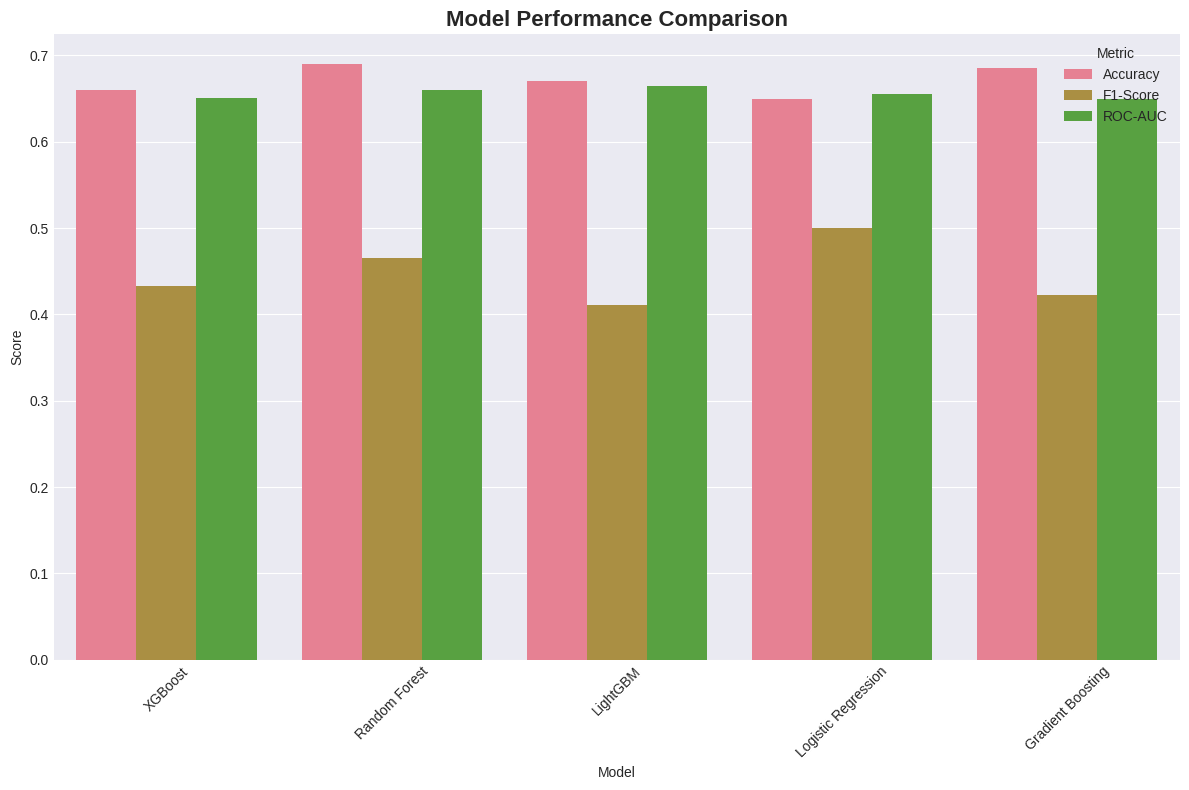

In [11]:
print("\n" + "="*80)
print("BUILDING AND COMPARING MODELS WITH TRAIN/VALIDATION LOSS CURVES:")
print("="*80)

# Ensure we have train/validation split for ALL models
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

models = {
    'XGBoost': XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42, eval_metric='logloss'),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight='balanced', n_jobs=-1, oob_score=True),
    'LightGBM': LGBMClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42, class_weight='balanced', verbosity=-1),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42, subsample=0.8, validation_fraction=0.1, n_iter_no_change=10)
}

results = []
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    # Train/Validation loss curves for ALL models
    plt.figure(figsize=(10, 6))

    if model_name == 'XGBoost':
        model.fit(X_train_split, y_train_split,
                  eval_set=[(X_train_split, y_train_split), (X_val, y_val)],
                  verbose=False)
        evals = model.evals_result()
        plt.plot(evals['validation_0']['logloss'], label='Train Loss', linewidth=2)
        plt.plot(evals['validation_1']['logloss'], label='Validation Loss', linewidth=2)
        plt.title(f'{model_name} - Train vs Validation Loss', fontsize=14)

    elif model_name == 'LightGBM':
        model.fit(X_train_split, y_train_split,
                  eval_set=[(X_train_split, y_train_split), (X_val, y_val)],
                  callbacks=[lgb.early_stopping(10), lgb.log_evaluation(0)])
        evals = model.evals_result_
        plt.plot(evals['training']['binary_logloss'], label='Train Loss', linewidth=2)
        plt.plot(evals['valid_1']['binary_logloss'], label='Validation Loss', linewidth=2)
        plt.title(f'{model_name} - Train vs Validation Loss', fontsize=14)

    elif model_name == 'Gradient Boosting':
        model.fit(X_train_split, y_train_split)

        #  CORRECT METHOD: Use staged_predict_proba directly
        train_staged_proba = model.staged_predict_proba(X_train_split)
        val_staged_proba = model.staged_predict_proba(X_val)

        # Calculate losses for each stage
        train_losses = [log_loss(y_train_split, proba[:, 1]) for proba in train_staged_proba]
        val_losses = [log_loss(y_val, proba[:, 1]) for proba in val_staged_proba]

        plt.plot(train_losses, label='Train Loss', linewidth=2)
        plt.plot(val_losses, label='Validation Loss', linewidth=2)
        plt.title(f'{model_name} - Train vs Validation Loss', fontsize=14)


    elif model_name == 'Random Forest':
        # Progressive training for loss curves
        train_losses, val_losses = [], []
        n_estimators_range = [10, 25, 50, 75, 100, 150, 200]

        for n_est in n_estimators_range:
            temp_model = RandomForestClassifier(n_estimators=n_est, max_depth=10, random_state=42,
                                               class_weight='balanced', n_jobs=-1, warm_start=True)
            temp_model.fit(X_train_split, y_train_split)

            train_pred = temp_model.predict_proba(X_train_split)[:, 1]
            val_pred = temp_model.predict_proba(X_val)[:, 1]
            train_losses.append(log_loss(y_train_split, train_pred))
            val_losses.append(log_loss(y_val, val_pred))

        plt.plot(n_estimators_range, train_losses, label='Train Loss', linewidth=2)
        plt.plot(n_estimators_range, val_losses, label='Validation Loss', linewidth=2)
        plt.title(f'{model_name} - Train vs Validation Loss (vs n_estimators)', fontsize=14)
        model.fit(X_train_resampled, y_train_resampled)  # Final model

    else:  # Logistic Regression
        # Progressive training by max_iter
        max_iters = [10, 50, 100, 200, 500, 1000]
        train_losses, val_losses = [], []

        for max_it in max_iters:
            temp_model = LogisticRegression(max_iter=max_it, random_state=42, class_weight='balanced')
            temp_model.fit(X_train_split, y_train_split)

            train_pred = temp_model.predict_proba(X_train_split)[:, 1]
            val_pred = temp_model.predict_proba(X_val)[:, 1]
            train_losses.append(log_loss(y_train_split, train_pred))
            val_losses.append(log_loss(y_val, val_pred))

        plt.plot(max_iters, train_losses, label='Train Loss', linewidth=2)
        plt.plot(max_iters, val_losses, label='Validation Loss', linewidth=2)
        plt.title(f'{model_name} - Train vs Validation Loss (vs Iterations)', fontsize=14)
        model.fit(X_train_resampled, y_train_resampled)  # Final model

    # Finalize plot styling
    plt.xlabel('Iterations/Epochs', fontsize=12)
    plt.ylabel('Log Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_train_val_loss.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Final evaluation on test set (using full resampled training data where applicable)
    if model_name not in ['Random Forest', 'Logistic Regression']:
        model.fit(X_train_resampled, y_train_resampled)

    y_pred = model.predict(X_test_selected)
    y_proba = model.predict_proba(X_test_selected)[:, 1]

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })

    print(f" Accuracy: {accuracy:.4f} | F1: {f1:.4f} | ROC-AUC: {roc_auc:.4f}")

# Final comparison
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("FINAL MODEL RANKING (by ROC-AUC):")
print("="*80)
print(results_df.sort_values('ROC-AUC', ascending=False).round(4).to_string(index=False))

# Comparison bar plot
plt.figure(figsize=(12, 8))
results_melted = results_df.melt(id_vars='Model', value_vars=['Accuracy', 'F1-Score', 'ROC-AUC'],
                                var_name='Metric', value_name='Score')
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Score')
plt.legend(title='Metric')
plt.tight_layout()
plt.savefig('final_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


In [12]:
# ====================================================================
# STEP 9: HYPERPARAMETER TUNING FOR BEST MODEL
# ====================================================================
print("\n" + "="*80)
print("HYPERPARAMETER TUNING:")
print("="*80)
# Select best model
best_model_name = results_df.loc[results_df['ROC-AUC'].idxmax(), 'Model']
print(f"\nSelected {best_model_name} for tuning")
# Define parameter grids
if best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9]
    }
    base_model = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)

elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    base_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

elif best_model_name == 'LightGBM':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [15, 31, 50]
    }
    base_model = LGBMClassifier(random_state=42, verbosity=-1)

else:
    param_grid = {
        'C': [0.01, 0.1, 1, 10],
        'max_iter': [1000, 2000]
    }
    base_model = models[best_model_name]
# Randomized search
print(f"\nTuning {best_model_name}...")
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=0
)
random_search.fit(X_train_resampled, y_train_resampled)
print(f"Best parameters: {random_search.best_params_}")
print(f"Best CV score: {random_search.best_score_:.4f}")
best_model = random_search.best_estimator_


HYPERPARAMETER TUNING:

Selected LightGBM for tuning

Tuning LightGBM...
Best parameters: {'num_leaves': 15, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05}
Best CV score: 0.8599



FINAL EVALUATION:

FINAL LightGBM RESULTS:
----------------------------------------
Accuracy: 0.7200
Precision: 0.5357
Recall: 0.5000
F1-Score: 0.5172
ROC-AUC: 0.6799

Classification Report:
----------------------------------------
              precision    recall  f1-score   support

   Good Risk       0.79      0.81      0.80       140
    Bad Risk       0.54      0.50      0.52        60

    accuracy                           0.72       200
   macro avg       0.66      0.66      0.66       200
weighted avg       0.71      0.72      0.72       200



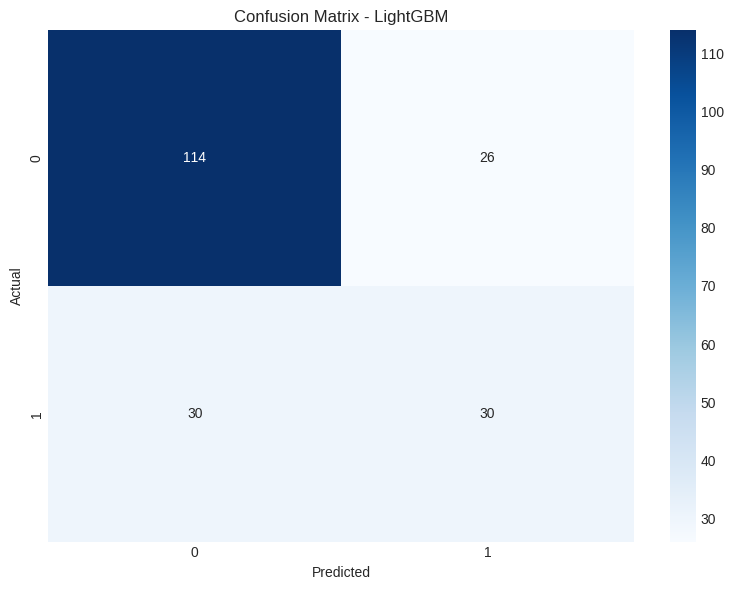

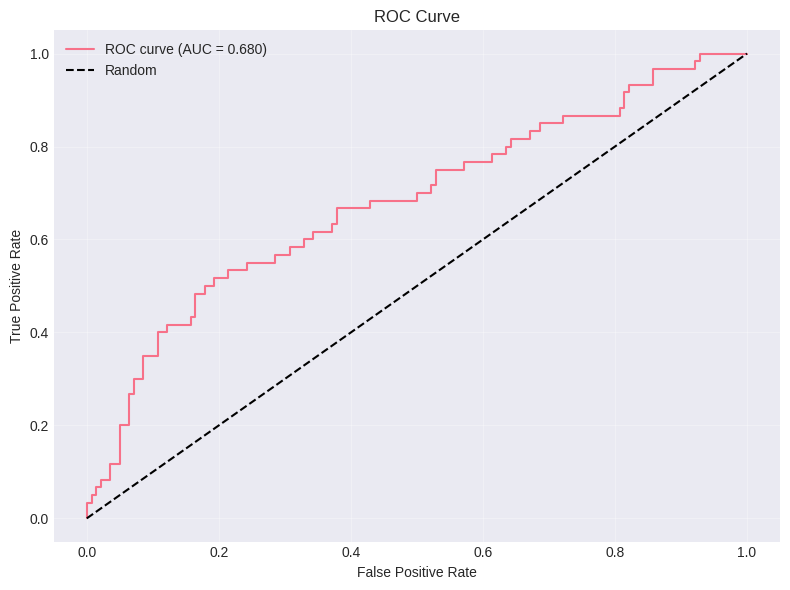

In [13]:
# ====================================================================
# STEP 10: FINAL EVALUATION
# ====================================================================
print("\n" + "="*80)
print("FINAL EVALUATION:")
print("="*80)
# Make predictions
y_pred_final = best_model.predict(X_test_selected)
y_proba_final = best_model.predict_proba(X_test_selected)[:, 1]
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_final)
precision = precision_score(y_test, y_pred_final)
recall = recall_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final)
roc_auc = roc_auc_score(y_test, y_proba_final)
print(f"\nFINAL {best_model_name} RESULTS:")
print("-" * 40)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
# Classification report
print("\nClassification Report:")
print("-" * 40)
print(classification_report(y_test, y_pred_final, target_names=['Good Risk', 'Bad Risk']))
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=100)
plt.show()
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba_final)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=100)
plt.show()

In [14]:
# ====================================================================
# STEP 11: THRESHOLD OPTIMIZATION
# ====================================================================
print("\n" + "="*80)
print("THRESHOLD OPTIMIZATION:")
print("="*80)
# Find optimal threshold
from sklearn.metrics import fbeta_score
thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []
for threshold in thresholds:
    y_pred_thresh = (y_proba_final >= threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh))
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"F1-Score at optimal threshold: {f1_scores[optimal_idx]:.4f}")
# Use optimal threshold
y_pred_optimal = (y_proba_final >= optimal_threshold).astype(int)
print("\nOptimized Classification Report:")
print("-" * 40)
print(classification_report(y_test, y_pred_optimal, target_names=['Good Risk', 'Bad Risk']))


THRESHOLD OPTIMIZATION:
Optimal threshold: 0.450
F1-Score at optimal threshold: 0.5203

Optimized Classification Report:
----------------------------------------
              precision    recall  f1-score   support

   Good Risk       0.80      0.78      0.79       140
    Bad Risk       0.51      0.53      0.52        60

    accuracy                           0.70       200
   macro avg       0.65      0.66      0.65       200
weighted avg       0.71      0.70      0.71       200




FEATURE IMPORTANCE:

Top 10 Most Important Features:
----------------------------------------
                 Feature  Importance
      Credit_amount_sqrt          99
                Duration          98
            housing_risk          98
credit_per_month_squared          96
     credit_to_age_ratio          89
  credit_to_income_ratio          85
          Checking_200.0          81
    credit_per_month_log          73
                     Age          71
       saving_risk_score          68


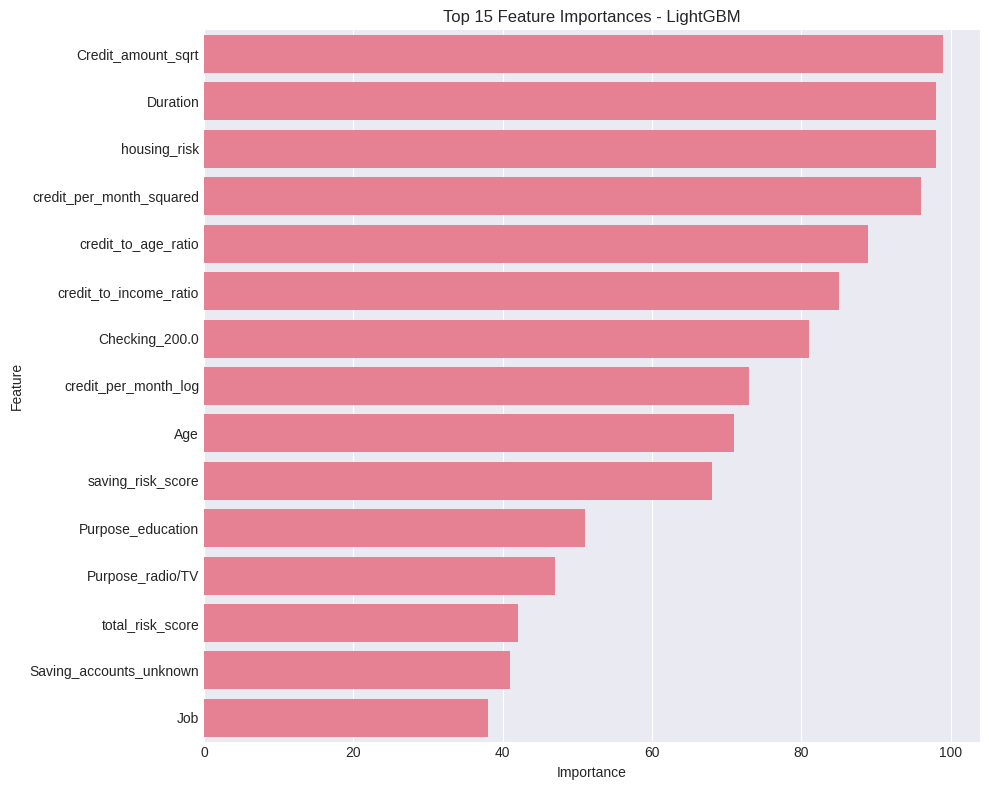

In [15]:
# ====================================================================
# STEP 12: FEATURE IMPORTANCE
# ====================================================================
print("\n" + "="*80)
print("FEATURE IMPORTANCE:")
print("="*80)
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X_train_selected.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print("\nTop 10 Most Important Features:")
    print("-" * 40)
    print(feature_importance_df.head(10).to_string(index=False))

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    top_features_imp = feature_importance_df.head(15)
    sns.barplot(x='Importance', y='Feature', data=top_features_imp)
    plt.title(f'Top 15 Feature Importances - {best_model_name}')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=100)
    plt.show()

In [16]:
# ====================================================================
# STEP 13: CROSS-VALIDATION FOR ROBUSTNESS
# ====================================================================
print("\n" + "="*80)
print("CROSS-VALIDATION RESULTS:")
print("="*80)
# Cross-validation
cv_scores = cross_val_score(
    best_model,
    X_train_resampled,
    y_train_resampled,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
print(f"Cross-validation ROC-AUC scores: {cv_scores}")
print(f"Mean CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


CROSS-VALIDATION RESULTS:
Cross-validation ROC-AUC scores: [0.71771365 0.7084662  0.93279656 0.98214286 0.97767857]
Mean CV ROC-AUC: 0.8638 (+/- 0.2485)


In [17]:

# ====================================================================
# STEP 14: SAVE THE MODEL
# ====================================================================
print("\n" + "="*80)
print("SAVING MODEL:")
print("="*80)
import joblib
import json
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# Save model
model_filename = f'credit_risk_model_{best_model_name}_{timestamp}.pkl'
joblib.dump(best_model, model_filename)
print(f"✓ Model saved as: {model_filename}")
# Save preprocessing info
preprocessing_info = {
    'selected_features': top_features,
    'optimal_threshold': optimal_threshold,
    'timestamp': timestamp
}
preprocessing_filename = f'preprocessing_info_{timestamp}.pkl'
joblib.dump(preprocessing_info, preprocessing_filename)
print(f"✓ Preprocessing info saved as: {preprocessing_filename}")
# Save metrics
metrics = {
    'model': best_model_name,
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'roc_auc': float(roc_auc),
    'optimal_threshold': float(optimal_threshold),
    'cv_mean_roc_auc': float(cv_scores.mean()),
    'cv_std_roc_auc': float(cv_scores.std())
}
metrics_filename = f'model_metrics_{timestamp}.json'
with open(metrics_filename, 'w') as f:
    json.dump(metrics, f, indent=4)
print(f"✓ Metrics saved as: {metrics_filename}")
print("\n" + "="*80)
print("PROCESS COMPLETED!")
print("="*80)
print(f"\nFinal Model: {best_model_name}")
print(f"Final Accuracy: {accuracy:.2%}")
print(f"Final F1-Score: {f1:.2%}")
print(f"Final ROC-AUC: {roc_auc:.2%}")


SAVING MODEL:
✓ Model saved as: credit_risk_model_LightGBM_20260106_075116.pkl
✓ Preprocessing info saved as: preprocessing_info_20260106_075116.pkl
✓ Metrics saved as: model_metrics_20260106_075116.json

PROCESS COMPLETED!

Final Model: LightGBM
Final Accuracy: 72.00%
Final F1-Score: 51.72%
Final ROC-AUC: 67.99%
